<a href="https://colab.research.google.com/github/phoen9/Classwork/blob/main/Sensitivity__CO2_Emission_EPC_LondonC_ANN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Use the right version of Tensor flow**

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
!pip install wandb -qqq
import wandb

**Import relevant modules**

In [ ]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [ ]:
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import random
import math


**Allow access to files on google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Log in to your W&B account
wandb.login()

wandb: Currently logged in as: essienai (use `wandb login --relogin` to force relogin)


True

**Load the Dataset**

In [ ]:
Data=pd.read_csv('/content/drive/My Drive/EPC_Londonc.csv') #to load data from my google drive

In [ ]:
training_data = Data.sample(frac=0.8, random_state=25)
testing_data = Data.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 443215
No. of testing examples: 110804


In [ ]:
training_data.head()

,CURRENT_ENERGY_RATING,PROPERTY_TYPE,BUILT_FORM,ENVIRONMENT_IMPACT_CURRENT,ENERGY_CONSUMPTION_CURRENT,CO2_EMISSIONS_CURRENT,TOTAL_FLOOR_AREA,MAINS_GAS_FLAG,GLAZED_AREA,FLOOR_DESCRIPTION,WINDOWS_DESCRIPTION,WINDOWS_ENERGY_EFF,WALLS_DESCRIPTION,WALLS_ENERGY_EFF,ROOF_DESCRIPTION,MAIN_FUEL,FLOOR_HEIGHT,VOLUME,MECHANICAL_VENTILATION,CONSTRUCTION_AGE_BAND
35080,C,House,Mid-Terrace,69,164,4.0,126.4,Y,Normal,"Solid, no insulation (assumed)",Fully double glazed,Average,"Cavity wall, as built, partial insulation (ass...",Average,"Pitched, 100 mm loft insulation",mains gas (not community),2.3,289.4,natural,F
194484,C,Maisonette,Detached,70,217,2.7,75.1,Y,Normal,(other premises below),Fully double glazed,Average,"System built, as built, no insulation (assumed)",Very Poor,"Pitched, 200mm loft insulation",mains gas - this is for backwards compatibilit...,2.4,180.2,natural,E
397850,D,Flat,Detached,53,307,4.0,67.7,Y,Normal,(other premises below),Fully double glazed,Good,"Solid brick, as built, no insulation (assumed)",Very Poor,"Pitched, no insulation(assumed)",mains gas (not community),2.6,176.0,natural,B
299929,F,Flat,Detached,26,972,5.7,38.7,N,Normal,"Solid, no insulation (assumed)",Some double glazing,Poor,"Solid brick, as built, no insulation (assumed)",Very Poor,(another dwelling above),electricity - this is for backwards compatibil...,2.5,96.8,natural,B
163219,C,Flat,Mid-Terrace,77,201,1.6,46.8,Y,Normal,(other premises below),Fully double glazed,Average,"Solid brick, as built, no insulation (assumed)",Very Poor,(another dwelling above),mains gas - this is for backwards compatibilit...,2.4,112.3,natural,C


In [ ]:
train_df=training_data[['ENVIRONMENT_IMPACT_CURRENT','ENERGY_CONSUMPTION_CURRENT','CO2_EMISSIONS_CURRENT','TOTAL_FLOOR_AREA','FLOOR_HEIGHT','VOLUME']]
test_df=testing_data[['ENVIRONMENT_IMPACT_CURRENT','ENERGY_CONSUMPTION_CURRENT','CO2_EMISSIONS_CURRENT','TOTAL_FLOOR_AREA','FLOOR_HEIGHT','VOLUME']]
train_df_cat=training_data[['CURRENT_ENERGY_RATING','PROPERTY_TYPE','BUILT_FORM','MAINS_GAS_FLAG','GLAZED_AREA','WINDOWS_ENERGY_EFF','WALLS_ENERGY_EFF','MAIN_FUEL','MECHANICAL_VENTILATION','CONSTRUCTION_AGE_BAND']]
test_df_cat=testing_data[['CURRENT_ENERGY_RATING','PROPERTY_TYPE','BUILT_FORM','MAINS_GAS_FLAG','GLAZED_AREA','WINDOWS_ENERGY_EFF','WALLS_ENERGY_EFF','MAIN_FUEL','MECHANICAL_VENTILATION','CONSTRUCTION_AGE_BAND']]
train_df.head()

,ENVIRONMENT_IMPACT_CURRENT,ENERGY_CONSUMPTION_CURRENT,CO2_EMISSIONS_CURRENT,TOTAL_FLOOR_AREA,FLOOR_HEIGHT,VOLUME
35080,69,164,4.0,126.4,2.3,289.4
194484,70,217,2.7,75.1,2.4,180.2
397850,53,307,4.0,67.7,2.6,176.0
299929,26,972,5.7,38.7,2.5,96.8
163219,77,201,1.6,46.8,2.4,112.3


**Normalize the Values**

In [ ]:
#@title Convert raw values to their Z-scores 

# Calculate the Z-scores of each column in the training set:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


In [ ]:
train_df_norm.head()

,ENVIRONMENT_IMPACT_CURRENT,ENERGY_CONSUMPTION_CURRENT,CO2_EMISSIONS_CURRENT,TOTAL_FLOOR_AREA,FLOOR_HEIGHT,VOLUME
35080,0.5,-1.0,0.3,1.5,-0.7,1.1
194484,0.6,-0.6,-0.3,0.2,-0.4,0.1
397850,-0.6,0.0,0.3,-0.0,0.2,0.0
299929,-2.6,4.8,1.0,-0.8,-0.1,-0.7
163219,1.1,-0.7,-0.8,-0.6,-0.4,-0.6


In [ ]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# It scaled all the columns
# Z scores. 
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# numeric cols
for header in ["TOTAL_FLOOR_AREA","FLOOR_HEIGHT","VOLUME"]:
  feature_columns.append(feature_column.numeric_column(header))

# indicator_columns
indicator_column_names = ['PROPERTY_TYPE','BUILT_FORM','GLAZED_AREA','FLOOR_DESCRIPTION','WINDOWS_DESCRIPTION','WINDOWS_ENERGY_EFF','WALLS_DESCRIPTION','WALLS_ENERGY_EFF','ROOF_DESCRIPTION','MAIN_FUEL','CONSTRUCTION_AGE_BAND']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, Data[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)


# crossed columns
Volume_type_feature = feature_column.crossed_column(['TOTAL_FLOOR_AREA','FLOOR_HEIGHT'], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(Volume_type_feature))


# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

**Deep neural network**

In [ ]:

def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

**Define training function**

In [ ]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, callbacks=[WandbCallback()]) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

**Define the plotting function**

In [ ]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


**Call functions to build and train Neural Network**

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
444/444 [==============================] - 34s 73ms/step - loss: 2.1671 - mean_squared_error: 2.1671
Epoch 2/15
444/444 [==============================] - 34s 76ms/step - loss: 1.2373 - mean_squared_error: 1.2373
Epoch 3/15
444/444 [==============================] - 33s 75ms/step - loss: 1.2178 - mean_squared_error: 1.2178
Epoch 4/15
444/444 [==============================] - 32s 73ms/step - loss: 1.1394 - mean_squared_error: 1.1394
Epoch 5/15
444/444 [==============================] - 32s 71ms/step - loss: 1.0855 - mean_squared_error: 1.0855
Epoch 6/15
444/444 [==============================] - 34s 77ms/step - loss: 1.1050 - mean_squared_error: 1.1050
Epoch 7/15
444/444 [==============================] - 34s 77ms/step - loss: 1.0482 - mean_squared_error: 1.0482
Epoch 8/15
444/444 [==============================] - 34s 78ms/step - loss: 1.0801 - mean_squared_error: 1

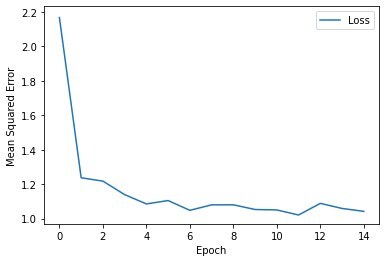


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
111/111 [==============================] - 3s 19ms/step - loss: 0.8981 - mean_squared_error: 0.8981


epoch,14
loss,mean_squared_error
mean_squared_error,1.04227


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁


In [ ]:
 wandb.init(
      project="CO2_Sensitivity",
      # Set entity to specify your username or team name
      # ex: entity="carey",
      config={
          "layer_1": 20,
          "activation_1": "relu",
          "dropout": random.uniform(0.01, 0.80),
          "layer_2": 12,
          "activation_2": "softmax",
          "optimizer": "sgd",
          "loss": "sparse_categorical_crossentropy",
          "metric": "accuracy",
          "epoch": 15,
          "learning_rate":0.01,
          "batch_size": 1000
      })
config = wandb.config

# The following variables are the hyperparameters.
learning_rate = config.learning_rate
epochs = config.epoch
batch_size = config.batch_size

# Specify the label
label_name = "CO2_EMISSIONS_CURRENT"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, training_data, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in testing_data.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

# 3. Log metrics over time to visualize performance
for i in range (10):
    wandb.log({"loss":"mean_squared_error"})

  # Mark the run as finished
wandb.finish()
